In [17]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension


In [19]:

def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

generator = build_generator()


In [20]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = build_discriminator()


In [21]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)


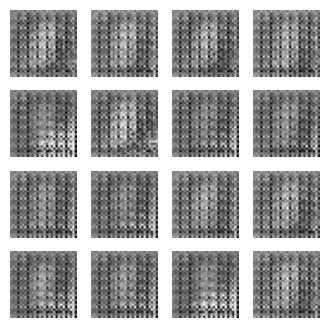

Epoch 1 completed


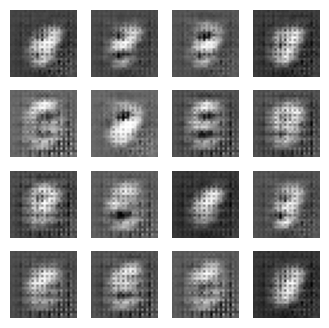

Epoch 2 completed


In [22]:
EPOCHS = 2
BATCH_SIZE = 256
BUFFER_SIZE = 60000
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

# Seed for visualizing progress
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

# Prepare the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Directory to save the weights
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

def save_weights(generator, discriminator, epoch):
    generator.save_weights(f'{checkpoint_prefix}_generator_epoch_{epoch}.weights.h5')
    discriminator.save_weights(f'{checkpoint_prefix}_discriminator_epoch_{epoch}.weights.h5')

def load_weights(generator, discriminator):
    latest_generator_ckpt = tf.train.latest_checkpoint(checkpoint_dir)
    latest_discriminator_ckpt = tf.train.latest_checkpoint(checkpoint_dir)

    if latest_generator_ckpt:
        generator.load_weights(latest_generator_ckpt)
        print("Loaded generator weights from", latest_generator_ckpt)

    if latest_discriminator_ckpt:
        discriminator.load_weights(latest_discriminator_ckpt)
        print("Loaded discriminator weights from", latest_discriminator_ckpt)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

def train(dataset, epochs):
    load_weights(generator, discriminator)  # Load weights before training

    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model weights at the end of each epoch
        save_weights(generator, discriminator, epoch + 1)

        print(f'Epoch {epoch + 1} completed')

    # Save the final model weights
    save_weights(generator, discriminator, epochs)

# Start training
train(train_dataset, EPOCHS)

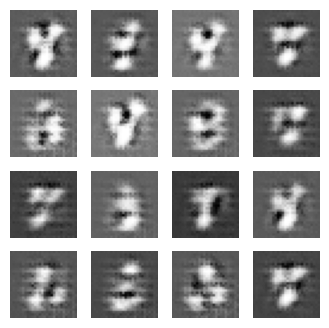

Epoch 1 completed


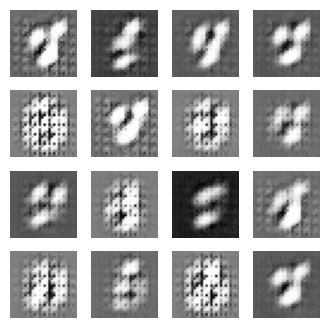

Epoch 2 completed


In [23]:
train(train_dataset, EPOCHS)

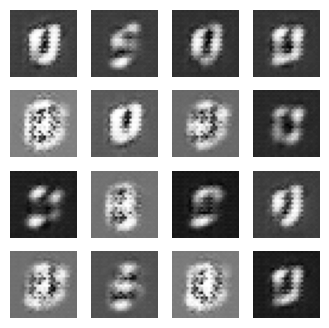

Epoch 1 completed


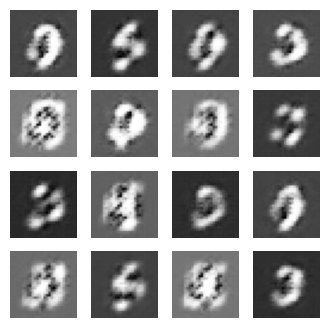

Epoch 2 completed


In [24]:
train(train_dataset, EPOCHS)


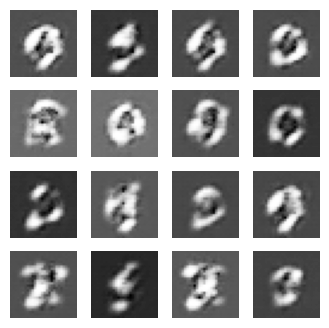

Epoch 1 completed


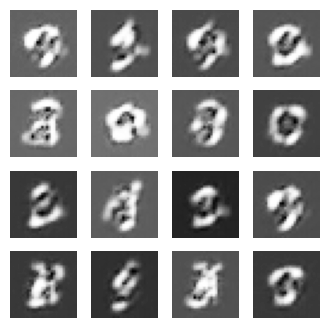

Epoch 2 completed


In [25]:
train(train_dataset, EPOCHS)

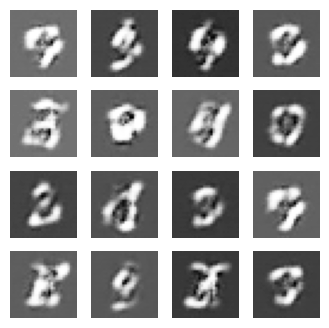

Epoch 1 completed


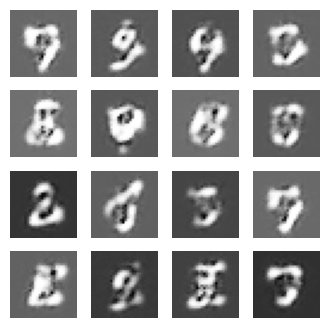

Epoch 2 completed


In [26]:
train(train_dataset, EPOCHS)

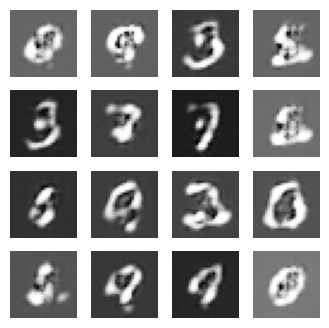

Epoch 1 completed


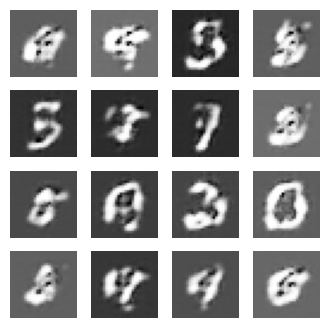

Epoch 2 completed


In [ ]:
train(train_dataset, EPOCHS)

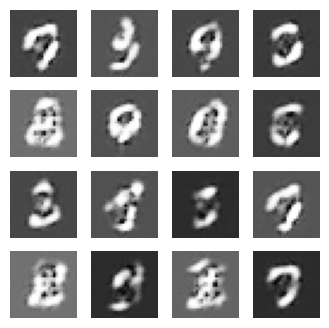

Epoch 1 completed


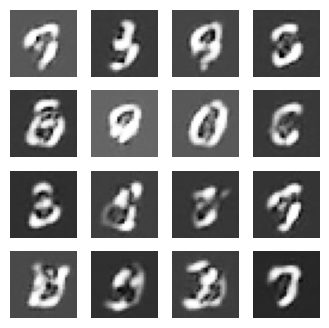

Epoch 2 completed


In [29]:
train(train_dataset, EPOCHS)

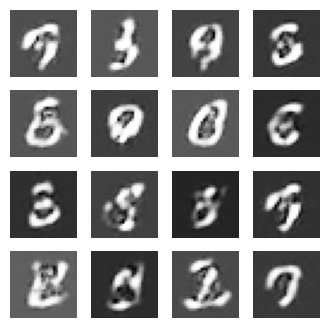

Epoch 1 completed


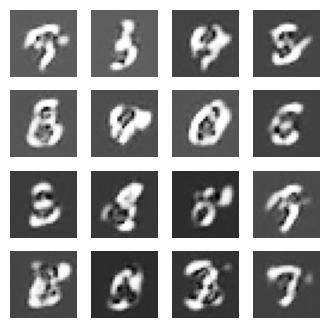

Epoch 2 completed


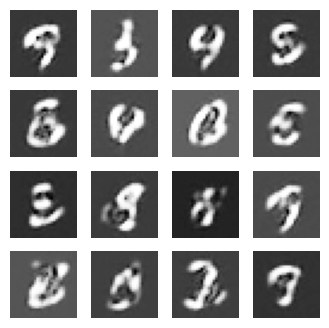

Epoch 3 completed


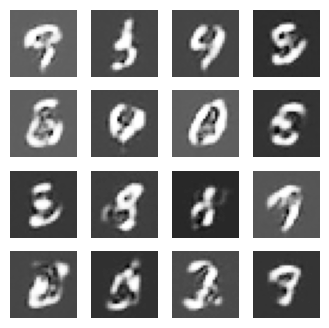

Epoch 4 completed


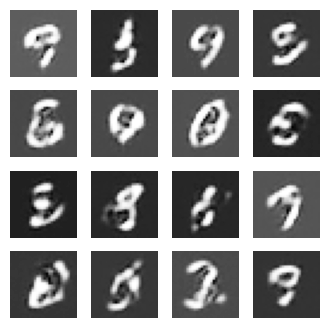

Epoch 5 completed


In [30]:
train(train_dataset, 5)

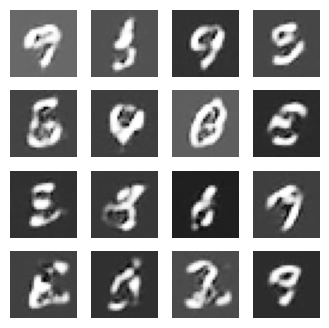

Epoch 1 completed


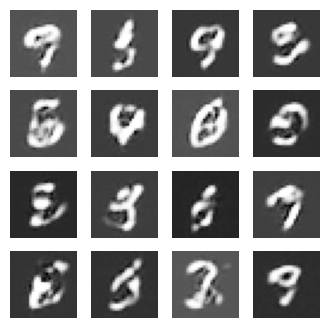

Epoch 2 completed


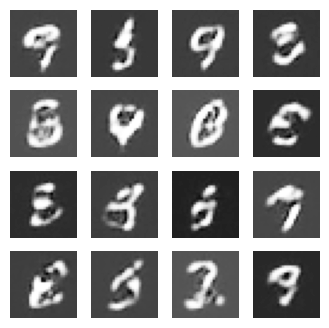

Epoch 3 completed


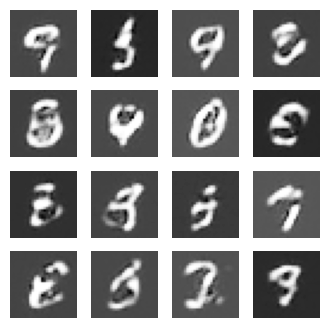

Epoch 4 completed


In [31]:
train(train_dataset, 4)

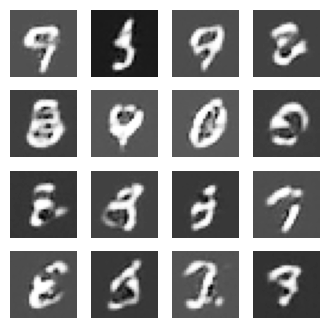

Epoch 1 completed


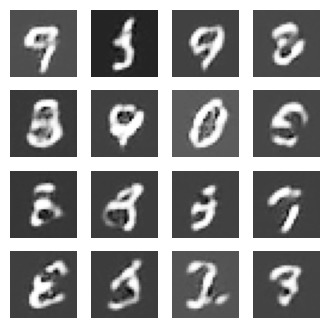

Epoch 2 completed


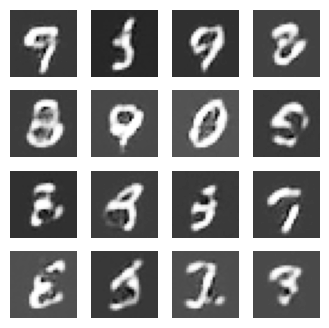

Epoch 3 completed


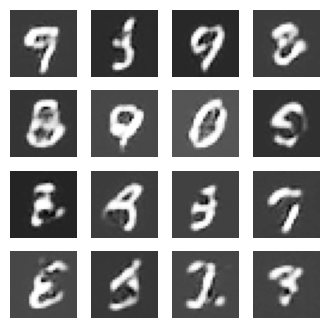

Epoch 4 completed


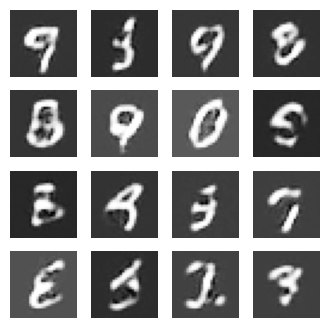

Epoch 5 completed


In [32]:
train(train_dataset, 5)

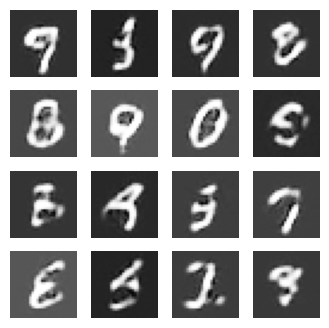

Epoch 1 completed


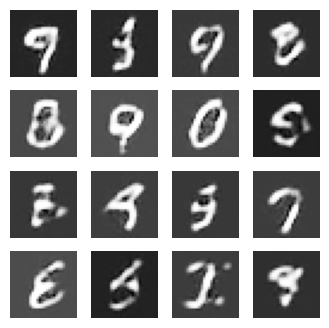

Epoch 2 completed


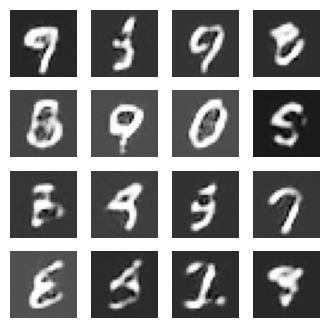

Epoch 3 completed


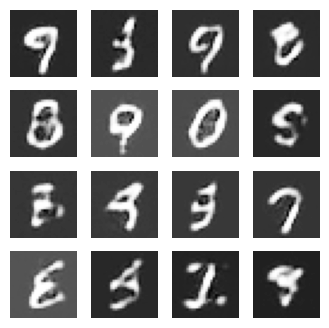

Epoch 4 completed


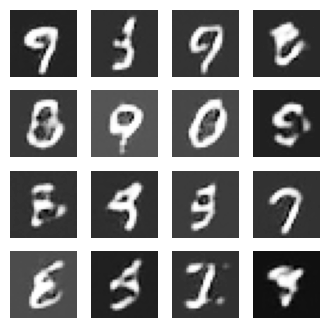

Epoch 5 completed


In [33]:
train(train_dataset, 5)

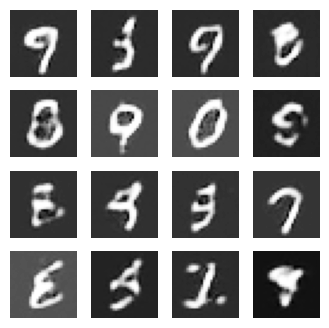

Epoch 1 completed


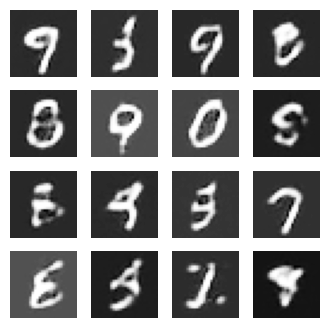

Epoch 2 completed


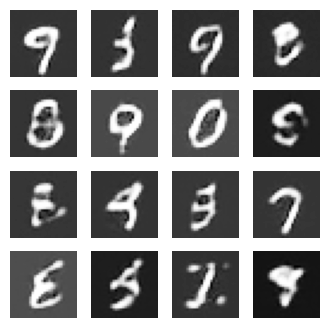

Epoch 3 completed


In [34]:
train(train_dataset, 5)